In [1]:
import math
import time
from pathlib import Path

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from data.data_loader import make_loader, XRays_CT_Dataset


from models.unet2d import unet
from models.fullmodel import MultiViewCT
from utils.metrics import psnr
from utils.volume_vis import show_triptych

In [2]:
ANGLES_DEG = [0, 45, 90, 135, 180]
ROOT = "../dataset"
DRR_SIZE = (128, 128)
CT_SIZE  = (128, 128, 128)


CKPT_DIR = Path("./checkpoints_model_fix")
CKPT_DIR.mkdir(parents=True, exist_ok=True)


EPOCHS        = 2000
BASE_LR       = 1e-5
WEIGHT_DECAY  = 1e-5
N_SAMPLES     = 131072
CHUNK_POINTS  = 8192
WARMUP_EPOCHS = 5

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
net2d = unet().to(device)
model = MultiViewCT(
    unet_2d=net2d,
    Z=CT_SIZE[0], Y=CT_SIZE[1], X=CT_SIZE[2],
    feat_ch=128,       # must match U-Net output channels
    pe_dim=9,
    inr_hidden=128,
    inr_blocks_view=3,
    inr_blocks_global=2,
    emb_dim=128,
    inr_out=1
).to(device)

print("Model ready on", device)

Model ready on cuda


In [5]:
loader = make_loader(
    root=ROOT,
    angles_deg=ANGLES_DEG,
    drr_size=DRR_SIZE,
    ct_size=CT_SIZE,
    batch_size=1,
    shuffle=True,
)

subset_loader = DataLoader(
    torch.utils.data.Subset(loader.dataset, [i for i in range(200)]),
    batch_size=1,
    shuffle=False,
)

len(subset_loader), len(loader.dataset)

(200, 266)

In [6]:

crit = nn.MSELoss()

optimG = optim.Adam(
    model.parameters(),
    lr=BASE_LR,
    weight_decay=WEIGHT_DECAY,
)

def lr_lambda(epoch):
    """
    - Linear warmup from 0 -> 1 during WARMUP_EPOCHS.
    - Then cosine decay from 1 -> 0.3.
    """
    if epoch < WARMUP_EPOCHS:
        return float(epoch + 1) / float(WARMUP_EPOCHS)
    else:
        t = (epoch - WARMUP_EPOCHS) / max(1, (EPOCHS - WARMUP_EPOCHS))
        cosine = 0.5 * (1 + math.cos(math.pi * t))  # 1 -> 0
        min_factor = 0.3
        return min_factor + (1 - min_factor) * cosine

scheduler = optim.lr_scheduler.LambdaLR(optimG, lr_lambda=lr_lambda)

# Training

In [7]:
def make_scheduler(optimG, last_epoch):
    return torch.optim.lr_scheduler.LambdaLR(
        optimG,
        lr_lambda=lr_lambda,
        last_epoch=last_epoch
    )

In [8]:
def train_model(
    model,
    optimG,
    scheduler_fn,
    CKPT_DIR,
    resume_epoch=None,
    total_epochs=EPOCHS,
):
    """
    Train or resume the model.

    model:      the neural network
    optimG:     optimizer instance
    scheduler_fn: a function that returns a scheduler given (optimG, start_epoch)
    CKPT_DIR:   folder containing checkpoints
    resume_epoch:
        None  : resume from latest checkpoint if any exists
        int>0 : resume from a specific epoch
        <=0   : start from scratch
    total_epochs:
        maximum number of epochs to train
    """

    start_epoch = 0
    ckpt_path = None

    ckpt_files = sorted(CKPT_DIR.glob("model_epoch*.pt"))

    if resume_epoch is None:
        # Use the latest checkpoint if any exists
        if ckpt_files:
            ckpt_path = ckpt_files[-1]

    elif isinstance(resume_epoch, int) and resume_epoch > 0:
        # Use a specific epoch checkpoint
        ckpt_name = f"model_epoch{resume_epoch:04d}.pt"
        candidate = CKPT_DIR / ckpt_name
        if candidate.exists():
            ckpt_path = candidate
        else:
            raise FileNotFoundError(f"Checkpoint not found: {candidate}")

    else:
        # resume_epoch <= 0 → start from scratch
        ckpt_path = None

    if ckpt_path is not None:
        print(f"Resuming from checkpoint: {ckpt_path}")
        ckpt = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optimG.load_state_dict(ckpt["optimizer_state"])
        start_epoch = ckpt.get("epoch", 0)

    else:
        print("No checkpoint loaded, starting from scratch.")
        start_epoch = 0

    # Recreate scheduler with the correct last_epoch
    scheduler = scheduler_fn(optimG, last_epoch=start_epoch - 1)

    print(f"Training will start at epoch {start_epoch+1} / {total_epochs}")
    print("Start training")

    for epoch in range(start_epoch, total_epochs):
        model.train()
        running_loss = 0.0
        n_batches = len(subset_loader)

        for batch_idx, batch in enumerate(subset_loader):
            views  = batch["views"].to(device, dtype=torch.float32)    # (B, V, 1, H, W)
            angles = batch["angles"].to(device, dtype=torch.float32)   # (B, V)
            ct     = batch["ct"].to(device, dtype=torch.float32)       # (B, 1, Z, Y, X)

            # Handle shape (B, 1, 1, Z, Y, X) : squeeze extra dim
            if ct.ndim == 6 and ct.shape[2] == 1:
                ct = ct.squeeze(2)

            B, _, Z, Y, X = ct.shape
            N_vox = Z * Y * X

            assert N_vox == model.coords.shape[0], (
                f"Grid mismatch: ct has {N_vox} voxels, "
                f"coords has {model.coords.shape[0]}"
            )

            # Random voxel sampling
            n_use = min(N_SAMPLES, N_vox)
            perm  = torch.randperm(N_vox, device=device)
            idx   = perm[:n_use]

            ct_flat = ct.view(B, -1)
            gt      = ct_flat[:, idx]

            # Forward only on sampled points
            optimG.zero_grad(set_to_none=True)
            pred = model.forward_points(
                views, angles, idx, chunk=CHUNK_POINTS
            )

            loss = crit(pred, gt)
            loss.backward()
            optimG.step()

            running_loss += loss.item()

            if (batch_idx + 1) % 20 == 0:
                print(
                    f"  epoch {epoch+1} | batch {batch_idx+1}/{n_batches} "
                    f"| loss={loss.item():.4e}",
                    end="\r",
                )

        avg_mse  = running_loss / n_batches
        avg_psnr = psnr(avg_mse)
        current_lr = optimG.param_groups[0]["lr"]

        print(
            f"Epoch {epoch+1}/{total_epochs} "
            f"LR:{current_lr:.2e} | "
            f"MSE(subset):{avg_mse:.4e} | PSNR~:{avg_psnr:.2f} dB"
        )

        scheduler.step()

        # Full-volume visualisation every 20 epochs
        if (epoch + 1) % 20 == 0:
            model.eval()
            with torch.no_grad():
                sample = loader.dataset[0]
                v = sample["views"].unsqueeze(0).to(device, dtype=torch.float32)
                a = sample["angles"].unsqueeze(0).to(device, dtype=torch.float32)
                ct_ref = sample["ct"].unsqueeze(0).to(device, dtype=torch.float32)
                if ct_ref.ndim == 6 and ct_ref.shape[2] == 1:
                    ct_ref = ct_ref.squeeze(2)
                pred_full = model(v, a, chunk=CHUNK_POINTS)

            show_triptych(
                pred_full[0, 0].cpu().numpy(),
                ct_ref[0, 0].cpu().numpy(),
                title_prefix=f"Epoch {epoch+1} (full volume)",
            )
            model.train()

        # Checkpoints
        if (epoch + 1) % 10 == 0 or (epoch + 1) == total_epochs:
            ckpt_path = CKPT_DIR / f"model_epoch{epoch+1:04d}.pt"
            torch.save(
                {
                    "epoch": epoch + 1,
                    "model_state": model.state_dict(),
                    "optimizer_state": optimG.state_dict(),
                    "loss": avg_mse,
                },
                ckpt_path,
            )
            print(f"Checkpoint : {ckpt_path}")

Resuming from checkpoint: checkpoints_model_fix/model_epoch0910.pt
Training will start at epoch 911 / 2000
Start training
Epoch 911/2000 LR:7.01e-06 | MSE(subset):4.9021e-03 | PSNR~:23.10 dB
Epoch 912/2000 LR:7.00e-06 | MSE(subset):4.9678e-03 | PSNR~:23.04 dB
Epoch 913/2000 LR:7.00e-06 | MSE(subset):4.9388e-03 | PSNR~:23.06 dB
Epoch 914/2000 LR:6.99e-06 | MSE(subset):4.9419e-03 | PSNR~:23.06 dB
Epoch 915/2000 LR:6.99e-06 | MSE(subset):4.8959e-03 | PSNR~:23.10 dB
Epoch 916/2000 LR:6.98e-06 | MSE(subset):4.9686e-03 | PSNR~:23.04 dB
Epoch 917/2000 LR:6.98e-06 | MSE(subset):4.9872e-03 | PSNR~:23.02 dB
Epoch 918/2000 LR:6.97e-06 | MSE(subset):4.9990e-03 | PSNR~:23.01 dB
Epoch 919/2000 LR:6.96e-06 | MSE(subset):5.0075e-03 | PSNR~:23.00 dB
Epoch 920/2000 LR:6.96e-06 | MSE(subset):4.9136e-03 | PSNR~:23.09 dB


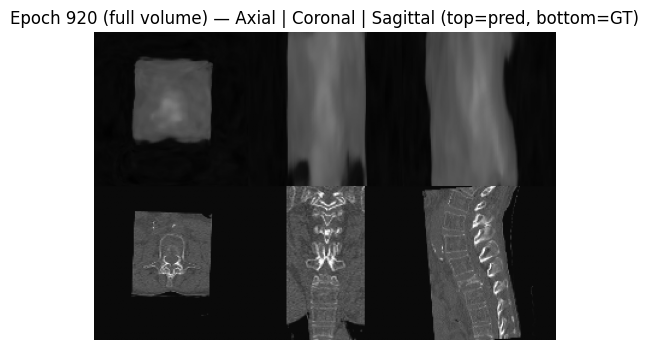

Checkpoint : checkpoints_model_fix/model_epoch0920.pt
Epoch 921/2000 LR:6.95e-06 | MSE(subset):4.9177e-03 | PSNR~:23.08 dB
Epoch 922/2000 LR:6.95e-06 | MSE(subset):4.9160e-03 | PSNR~:23.08 dB
Epoch 923/2000 LR:6.94e-06 | MSE(subset):4.8854e-03 | PSNR~:23.11 dB
Epoch 924/2000 LR:6.94e-06 | MSE(subset):4.9230e-03 | PSNR~:23.08 dB
Epoch 925/2000 LR:6.93e-06 | MSE(subset):4.9086e-03 | PSNR~:23.09 dB
Epoch 926/2000 LR:6.93e-06 | MSE(subset):4.9021e-03 | PSNR~:23.10 dB
Epoch 927/2000 LR:6.92e-06 | MSE(subset):4.9934e-03 | PSNR~:23.02 dB
Epoch 928/2000 LR:6.92e-06 | MSE(subset):4.9220e-03 | PSNR~:23.08 dB
Epoch 929/2000 LR:6.91e-06 | MSE(subset):4.8776e-03 | PSNR~:23.12 dB
Epoch 930/2000 LR:6.90e-06 | MSE(subset):4.8778e-03 | PSNR~:23.12 dB
Checkpoint : checkpoints_model_fix/model_epoch0930.pt
Epoch 931/2000 LR:6.90e-06 | MSE(subset):4.9399e-03 | PSNR~:23.06 dB
Epoch 932/2000 LR:6.89e-06 | MSE(subset):4.9521e-03 | PSNR~:23.05 dB
Epoch 933/2000 LR:6.89e-06 | MSE(subset):4.9283e-03 | PSNR~:23.0

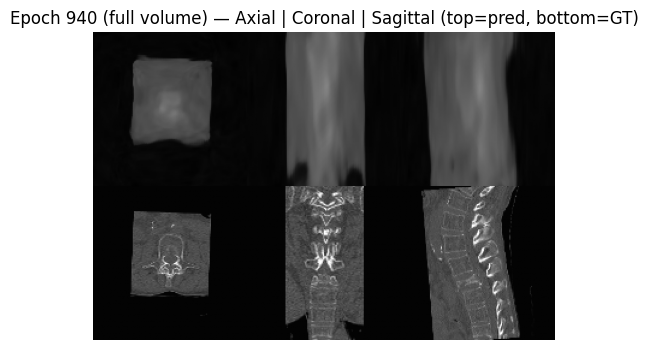

Checkpoint : checkpoints_model_fix/model_epoch0940.pt
Epoch 941/2000 LR:6.84e-06 | MSE(subset):4.7936e-03 | PSNR~:23.19 dB
Epoch 942/2000 LR:6.84e-06 | MSE(subset):4.8737e-03 | PSNR~:23.12 dB
Epoch 943/2000 LR:6.83e-06 | MSE(subset):4.8415e-03 | PSNR~:23.15 dB
Epoch 944/2000 LR:6.83e-06 | MSE(subset):4.7748e-03 | PSNR~:23.21 dB
Epoch 945/2000 LR:6.82e-06 | MSE(subset):4.8506e-03 | PSNR~:23.14 dB
Epoch 946/2000 LR:6.82e-06 | MSE(subset):4.8784e-03 | PSNR~:23.12 dB
Epoch 947/2000 LR:6.81e-06 | MSE(subset):4.9040e-03 | PSNR~:23.09 dB
Epoch 948/2000 LR:6.81e-06 | MSE(subset):4.8337e-03 | PSNR~:23.16 dB
Epoch 949/2000 LR:6.80e-06 | MSE(subset):4.8616e-03 | PSNR~:23.13 dB
Epoch 950/2000 LR:6.79e-06 | MSE(subset):4.8662e-03 | PSNR~:23.13 dB
Checkpoint : checkpoints_model_fix/model_epoch0950.pt
Epoch 951/2000 LR:6.79e-06 | MSE(subset):4.8630e-03 | PSNR~:23.13 dB
Epoch 952/2000 LR:6.78e-06 | MSE(subset):5.0161e-03 | PSNR~:23.00 dB
Epoch 953/2000 LR:6.78e-06 | MSE(subset):4.9130e-03 | PSNR~:23.0

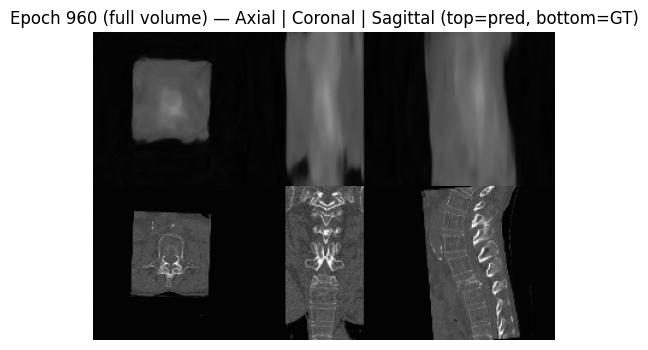

Checkpoint : checkpoints_model_fix/model_epoch0960.pt
Epoch 961/2000 LR:6.73e-06 | MSE(subset):5.0872e-03 | PSNR~:22.94 dB
Epoch 962/2000 LR:6.73e-06 | MSE(subset):5.0694e-03 | PSNR~:22.95 dB
Epoch 963/2000 LR:6.72e-06 | MSE(subset):4.9735e-03 | PSNR~:23.03 dB
Epoch 964/2000 LR:6.72e-06 | MSE(subset):4.9238e-03 | PSNR~:23.08 dB
Epoch 965/2000 LR:6.71e-06 | MSE(subset):4.9268e-03 | PSNR~:23.07 dB
Epoch 966/2000 LR:6.71e-06 | MSE(subset):4.9145e-03 | PSNR~:23.09 dB
Epoch 967/2000 LR:6.70e-06 | MSE(subset):4.8699e-03 | PSNR~:23.12 dB
Epoch 968/2000 LR:6.70e-06 | MSE(subset):4.8531e-03 | PSNR~:23.14 dB
Epoch 969/2000 LR:6.69e-06 | MSE(subset):4.9078e-03 | PSNR~:23.09 dB
Epoch 970/2000 LR:6.68e-06 | MSE(subset):4.9016e-03 | PSNR~:23.10 dB
Checkpoint : checkpoints_model_fix/model_epoch0970.pt
Epoch 971/2000 LR:6.68e-06 | MSE(subset):4.9961e-03 | PSNR~:23.01 dB
Epoch 972/2000 LR:6.67e-06 | MSE(subset):4.8790e-03 | PSNR~:23.12 dB
Epoch 973/2000 LR:6.67e-06 | MSE(subset):4.9455e-03 | PSNR~:23.0

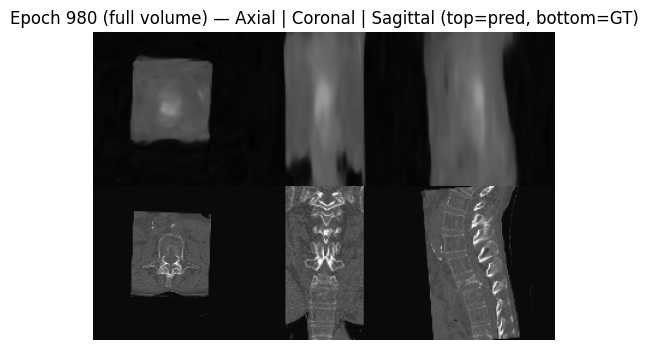

Checkpoint : checkpoints_model_fix/model_epoch0980.pt
Epoch 981/2000 LR:6.62e-06 | MSE(subset):4.8383e-03 | PSNR~:23.15 dB
Epoch 982/2000 LR:6.62e-06 | MSE(subset):4.8487e-03 | PSNR~:23.14 dB
Epoch 983/2000 LR:6.61e-06 | MSE(subset):4.8250e-03 | PSNR~:23.17 dB
Epoch 984/2000 LR:6.61e-06 | MSE(subset):4.7734e-03 | PSNR~:23.21 dB
Epoch 985/2000 LR:6.60e-06 | MSE(subset):4.8261e-03 | PSNR~:23.16 dB
Epoch 986/2000 LR:6.60e-06 | MSE(subset):4.8094e-03 | PSNR~:23.18 dB
Epoch 987/2000 LR:6.59e-06 | MSE(subset):4.7996e-03 | PSNR~:23.19 dB
Epoch 988/2000 LR:6.59e-06 | MSE(subset):4.8067e-03 | PSNR~:23.18 dB
Epoch 989/2000 LR:6.58e-06 | MSE(subset):4.7842e-03 | PSNR~:23.20 dB
Epoch 990/2000 LR:6.57e-06 | MSE(subset):4.7901e-03 | PSNR~:23.20 dB
Checkpoint : checkpoints_model_fix/model_epoch0990.pt
Epoch 991/2000 LR:6.57e-06 | MSE(subset):4.7644e-03 | PSNR~:23.22 dB
Epoch 992/2000 LR:6.56e-06 | MSE(subset):4.7671e-03 | PSNR~:23.22 dB
Epoch 993/2000 LR:6.56e-06 | MSE(subset):4.7967e-03 | PSNR~:23.1

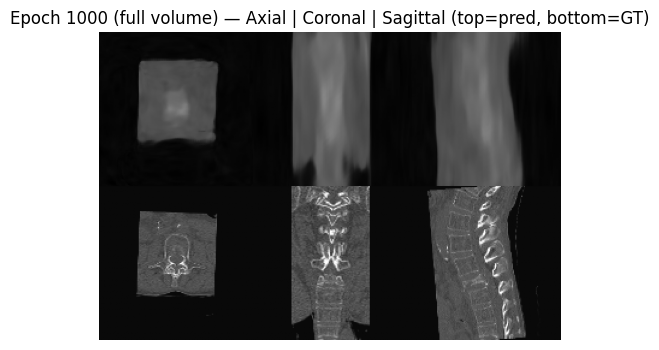

Checkpoint : checkpoints_model_fix/model_epoch1000.pt
Epoch 1001/2000 LR:6.51e-06 | MSE(subset):4.9226e-03 | PSNR~:23.08 dB
Epoch 1002/2000 LR:6.51e-06 | MSE(subset):4.7968e-03 | PSNR~:23.19 dB
Epoch 1003/2000 LR:6.50e-06 | MSE(subset):4.8322e-03 | PSNR~:23.16 dB
Epoch 1004/2000 LR:6.50e-06 | MSE(subset):4.7626e-03 | PSNR~:23.22 dB
Epoch 1005/2000 LR:6.49e-06 | MSE(subset):4.7508e-03 | PSNR~:23.23 dB
Epoch 1006/2000 LR:6.49e-06 | MSE(subset):4.7526e-03 | PSNR~:23.23 dB
Epoch 1007/2000 LR:6.48e-06 | MSE(subset):4.7076e-03 | PSNR~:23.27 dB
Epoch 1008/2000 LR:6.48e-06 | MSE(subset):4.6387e-03 | PSNR~:23.34 dB
Epoch 1009/2000 LR:6.47e-06 | MSE(subset):4.7300e-03 | PSNR~:23.25 dB
Epoch 1010/2000 LR:6.46e-06 | MSE(subset):4.7733e-03 | PSNR~:23.21 dB
Checkpoint : checkpoints_model_fix/model_epoch1010.pt
Epoch 1011/2000 LR:6.46e-06 | MSE(subset):4.7600e-03 | PSNR~:23.22 dB
Epoch 1012/2000 LR:6.45e-06 | MSE(subset):4.7487e-03 | PSNR~:23.23 dB
Epoch 1013/2000 LR:6.45e-06 | MSE(subset):4.7198e-03

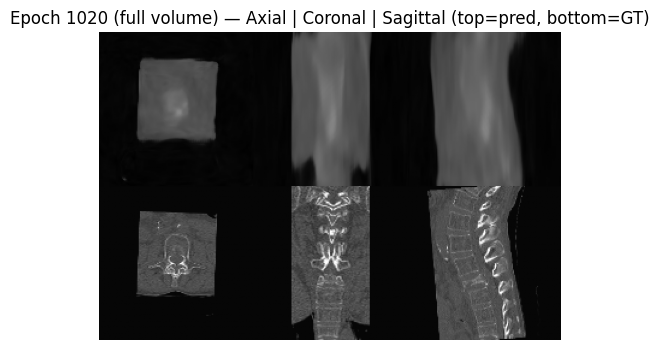

Checkpoint : checkpoints_model_fix/model_epoch1020.pt
Epoch 1021/2000 LR:6.40e-06 | MSE(subset):4.6928e-03 | PSNR~:23.29 dB
Epoch 1022/2000 LR:6.40e-06 | MSE(subset):4.7160e-03 | PSNR~:23.26 dB
Epoch 1023/2000 LR:6.39e-06 | MSE(subset):4.6784e-03 | PSNR~:23.30 dB
Epoch 1024/2000 LR:6.39e-06 | MSE(subset):4.6379e-03 | PSNR~:23.34 dB
Epoch 1025/2000 LR:6.38e-06 | MSE(subset):4.6315e-03 | PSNR~:23.34 dB
Epoch 1026/2000 LR:6.38e-06 | MSE(subset):4.6320e-03 | PSNR~:23.34 dB
Epoch 1027/2000 LR:6.37e-06 | MSE(subset):4.6663e-03 | PSNR~:23.31 dB
Epoch 1028/2000 LR:6.37e-06 | MSE(subset):4.6266e-03 | PSNR~:23.35 dB
Epoch 1029/2000 LR:6.36e-06 | MSE(subset):4.6115e-03 | PSNR~:23.36 dB
Epoch 1030/2000 LR:6.35e-06 | MSE(subset):4.6281e-03 | PSNR~:23.35 dB
Checkpoint : checkpoints_model_fix/model_epoch1030.pt
Epoch 1031/2000 LR:6.35e-06 | MSE(subset):4.5970e-03 | PSNR~:23.38 dB
Epoch 1032/2000 LR:6.34e-06 | MSE(subset):4.6630e-03 | PSNR~:23.31 dB
Epoch 1033/2000 LR:6.34e-06 | MSE(subset):4.6367e-03

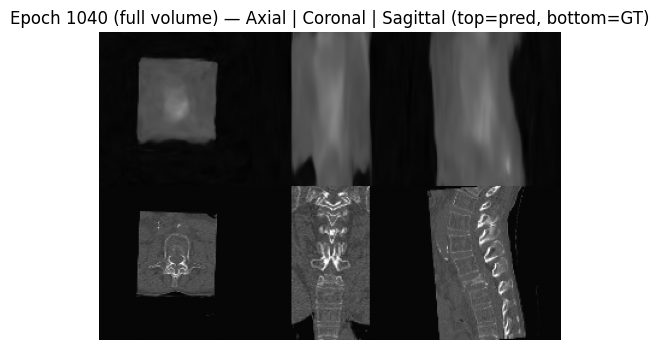

Checkpoint : checkpoints_model_fix/model_epoch1040.pt
Epoch 1041/2000 LR:6.29e-06 | MSE(subset):4.5921e-03 | PSNR~:23.38 dB
Epoch 1042/2000 LR:6.29e-06 | MSE(subset):4.6458e-03 | PSNR~:23.33 dB
Epoch 1043/2000 LR:6.28e-06 | MSE(subset):4.6520e-03 | PSNR~:23.32 dB
Epoch 1044/2000 LR:6.28e-06 | MSE(subset):4.7036e-03 | PSNR~:23.28 dB
Epoch 1045/2000 LR:6.27e-06 | MSE(subset):4.6350e-03 | PSNR~:23.34 dB
Epoch 1046/2000 LR:6.27e-06 | MSE(subset):4.6588e-03 | PSNR~:23.32 dB
Epoch 1047/2000 LR:6.26e-06 | MSE(subset):4.6768e-03 | PSNR~:23.30 dB
Epoch 1048/2000 LR:6.25e-06 | MSE(subset):4.6441e-03 | PSNR~:23.33 dB
Epoch 1049/2000 LR:6.25e-06 | MSE(subset):4.6248e-03 | PSNR~:23.35 dB
Epoch 1050/2000 LR:6.24e-06 | MSE(subset):4.5872e-03 | PSNR~:23.38 dB
Checkpoint : checkpoints_model_fix/model_epoch1050.pt
Epoch 1051/2000 LR:6.24e-06 | MSE(subset):4.5826e-03 | PSNR~:23.39 dB
Epoch 1052/2000 LR:6.23e-06 | MSE(subset):4.6190e-03 | PSNR~:23.35 dB
Epoch 1053/2000 LR:6.23e-06 | MSE(subset):4.6276e-03

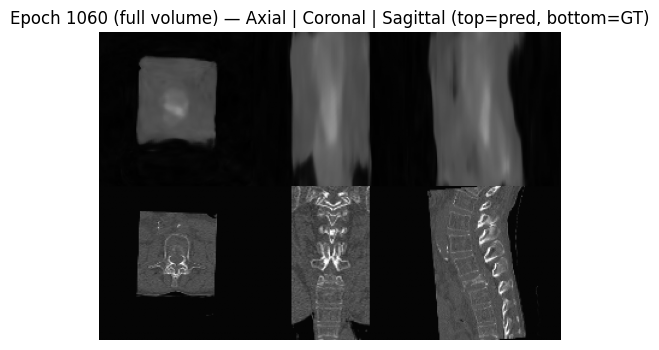

Checkpoint : checkpoints_model_fix/model_epoch1060.pt
Epoch 1061/2000 LR:6.18e-06 | MSE(subset):4.5810e-03 | PSNR~:23.39 dB
Epoch 1062/2000 LR:6.18e-06 | MSE(subset):4.5392e-03 | PSNR~:23.43 dB
Epoch 1063/2000 LR:6.17e-06 | MSE(subset):4.7147e-03 | PSNR~:23.27 dB
Epoch 1064/2000 LR:6.17e-06 | MSE(subset):4.5626e-03 | PSNR~:23.41 dB
Epoch 1065/2000 LR:6.16e-06 | MSE(subset):4.5846e-03 | PSNR~:23.39 dB
Epoch 1066/2000 LR:6.16e-06 | MSE(subset):4.6165e-03 | PSNR~:23.36 dB
Epoch 1067/2000 LR:6.15e-06 | MSE(subset):4.6091e-03 | PSNR~:23.36 dB
Epoch 1068/2000 LR:6.15e-06 | MSE(subset):4.5660e-03 | PSNR~:23.40 dB
Epoch 1069/2000 LR:6.14e-06 | MSE(subset):4.6291e-03 | PSNR~:23.35 dB
Epoch 1070/2000 LR:6.13e-06 | MSE(subset):4.6217e-03 | PSNR~:23.35 dB
Checkpoint : checkpoints_model_fix/model_epoch1070.pt
Epoch 1071/2000 LR:6.13e-06 | MSE(subset):4.5666e-03 | PSNR~:23.40 dB
Epoch 1072/2000 LR:6.12e-06 | MSE(subset):4.5662e-03 | PSNR~:23.40 dB
Epoch 1073/2000 LR:6.12e-06 | MSE(subset):4.5658e-03

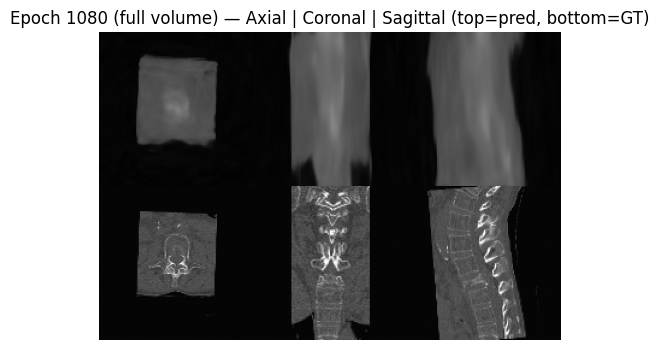

Checkpoint : checkpoints_model_fix/model_epoch1080.pt
Epoch 1081/2000 LR:6.07e-06 | MSE(subset):4.6330e-03 | PSNR~:23.34 dB
Epoch 1082/2000 LR:6.07e-06 | MSE(subset):4.5582e-03 | PSNR~:23.41 dB
Epoch 1083/2000 LR:6.06e-06 | MSE(subset):4.6022e-03 | PSNR~:23.37 dB
Epoch 1084/2000 LR:6.06e-06 | MSE(subset):4.6024e-03 | PSNR~:23.37 dB
Epoch 1085/2000 LR:6.05e-06 | MSE(subset):4.5335e-03 | PSNR~:23.44 dB
Epoch 1086/2000 LR:6.05e-06 | MSE(subset):4.5012e-03 | PSNR~:23.47 dB
Epoch 1087/2000 LR:6.04e-06 | MSE(subset):4.4863e-03 | PSNR~:23.48 dB
Epoch 1088/2000 LR:6.04e-06 | MSE(subset):4.4393e-03 | PSNR~:23.53 dB
Epoch 1089/2000 LR:6.03e-06 | MSE(subset):4.4351e-03 | PSNR~:23.53 dB
Epoch 1090/2000 LR:6.02e-06 | MSE(subset):4.4594e-03 | PSNR~:23.51 dB
Checkpoint : checkpoints_model_fix/model_epoch1090.pt
Epoch 1091/2000 LR:6.02e-06 | MSE(subset):4.4916e-03 | PSNR~:23.48 dB
Epoch 1092/2000 LR:6.01e-06 | MSE(subset):4.5320e-03 | PSNR~:23.44 dB
Epoch 1093/2000 LR:6.01e-06 | MSE(subset):4.5617e-03

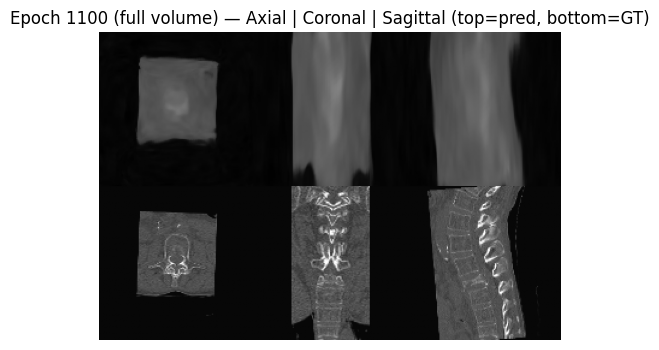

Checkpoint : checkpoints_model_fix/model_epoch1100.pt
Epoch 1101/2000 LR:5.96e-06 | MSE(subset):4.4844e-03 | PSNR~:23.48 dB
Epoch 1102/2000 LR:5.96e-06 | MSE(subset):4.5246e-03 | PSNR~:23.44 dB
Epoch 1103/2000 LR:5.95e-06 | MSE(subset):4.4710e-03 | PSNR~:23.50 dB
Epoch 1104/2000 LR:5.95e-06 | MSE(subset):4.4596e-03 | PSNR~:23.51 dB
Epoch 1105/2000 LR:5.94e-06 | MSE(subset):4.4287e-03 | PSNR~:23.54 dB
Epoch 1106/2000 LR:5.94e-06 | MSE(subset):4.5374e-03 | PSNR~:23.43 dB
Epoch 1107/2000 LR:5.93e-06 | MSE(subset):4.5285e-03 | PSNR~:23.44 dB
Epoch 1108/2000 LR:5.93e-06 | MSE(subset):4.4968e-03 | PSNR~:23.47 dB
Epoch 1109/2000 LR:5.92e-06 | MSE(subset):4.5103e-03 | PSNR~:23.46 dB
Epoch 1110/2000 LR:5.92e-06 | MSE(subset):4.4808e-03 | PSNR~:23.49 dB
Checkpoint : checkpoints_model_fix/model_epoch1110.pt
Epoch 1111/2000 LR:5.91e-06 | MSE(subset):4.4689e-03 | PSNR~:23.50 dB
Epoch 1112/2000 LR:5.90e-06 | MSE(subset):4.4915e-03 | PSNR~:23.48 dB
Epoch 1113/2000 LR:5.90e-06 | MSE(subset):4.5428e-03

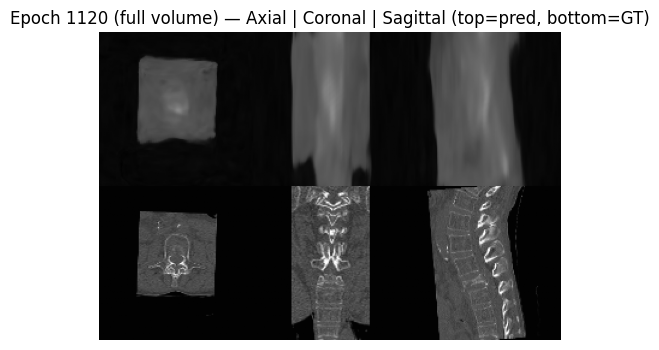

Checkpoint : checkpoints_model_fix/model_epoch1120.pt
Epoch 1121/2000 LR:5.86e-06 | MSE(subset):4.4875e-03 | PSNR~:23.48 dB
Epoch 1122/2000 LR:5.85e-06 | MSE(subset):4.4487e-03 | PSNR~:23.52 dB
Epoch 1123/2000 LR:5.85e-06 | MSE(subset):4.5310e-03 | PSNR~:23.44 dB
Epoch 1124/2000 LR:5.84e-06 | MSE(subset):4.5322e-03 | PSNR~:23.44 dB
Epoch 1125/2000 LR:5.83e-06 | MSE(subset):4.4786e-03 | PSNR~:23.49 dB
Epoch 1126/2000 LR:5.83e-06 | MSE(subset):4.5771e-03 | PSNR~:23.39 dB
Epoch 1127/2000 LR:5.82e-06 | MSE(subset):4.4568e-03 | PSNR~:23.51 dB
Epoch 1128/2000 LR:5.82e-06 | MSE(subset):4.4402e-03 | PSNR~:23.53 dB
Epoch 1129/2000 LR:5.81e-06 | MSE(subset):4.4665e-03 | PSNR~:23.50 dB
Epoch 1130/2000 LR:5.81e-06 | MSE(subset):4.4676e-03 | PSNR~:23.50 dB
Checkpoint : checkpoints_model_fix/model_epoch1130.pt
Epoch 1131/2000 LR:5.80e-06 | MSE(subset):4.4778e-03 | PSNR~:23.49 dB
Epoch 1132/2000 LR:5.80e-06 | MSE(subset):4.4249e-03 | PSNR~:23.54 dB
Epoch 1133/2000 LR:5.79e-06 | MSE(subset):4.3867e-03

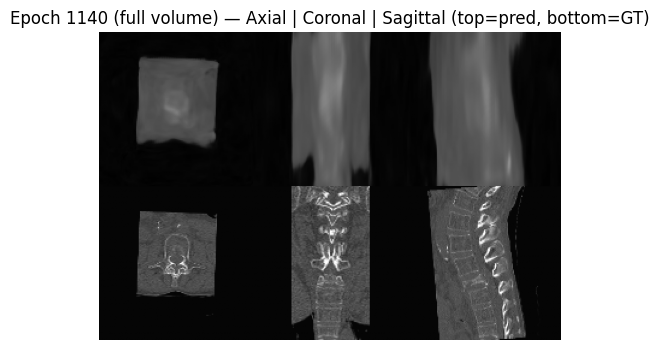

Checkpoint : checkpoints_model_fix/model_epoch1140.pt
Epoch 1141/2000 LR:5.75e-06 | MSE(subset):4.4963e-03 | PSNR~:23.47 dB
Epoch 1142/2000 LR:5.74e-06 | MSE(subset):4.4498e-03 | PSNR~:23.52 dB
Epoch 1143/2000 LR:5.74e-06 | MSE(subset):4.4267e-03 | PSNR~:23.54 dB
Epoch 1144/2000 LR:5.73e-06 | MSE(subset):4.4062e-03 | PSNR~:23.56 dB
Epoch 1145/2000 LR:5.73e-06 | MSE(subset):4.3919e-03 | PSNR~:23.57 dB
Epoch 1146/2000 LR:5.72e-06 | MSE(subset):4.4541e-03 | PSNR~:23.51 dB
Epoch 1147/2000 LR:5.72e-06 | MSE(subset):4.4527e-03 | PSNR~:23.51 dB
Epoch 1148/2000 LR:5.71e-06 | MSE(subset):4.4548e-03 | PSNR~:23.51 dB
Epoch 1149/2000 LR:5.71e-06 | MSE(subset):4.4492e-03 | PSNR~:23.52 dB
Epoch 1150/2000 LR:5.70e-06 | MSE(subset):4.5071e-03 | PSNR~:23.46 dB
Checkpoint : checkpoints_model_fix/model_epoch1150.pt
Epoch 1151/2000 LR:5.69e-06 | MSE(subset):4.5210e-03 | PSNR~:23.45 dB
Epoch 1152/2000 LR:5.69e-06 | MSE(subset):4.4863e-03 | PSNR~:23.48 dB
Epoch 1153/2000 LR:5.68e-06 | MSE(subset):4.4053e-03

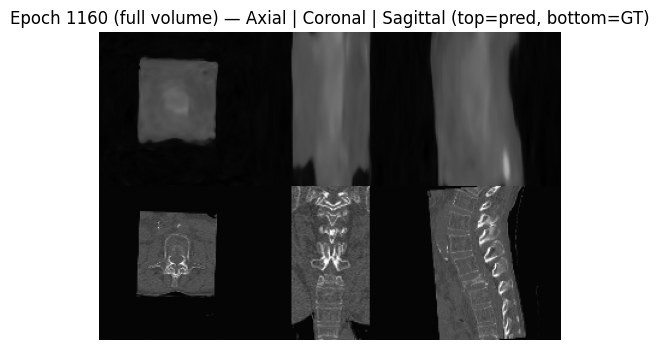

Checkpoint : checkpoints_model_fix/model_epoch1160.pt
Epoch 1161/2000 LR:5.64e-06 | MSE(subset):4.4126e-03 | PSNR~:23.55 dB
Epoch 1162/2000 LR:5.64e-06 | MSE(subset):4.4218e-03 | PSNR~:23.54 dB
Epoch 1163/2000 LR:5.63e-06 | MSE(subset):4.4116e-03 | PSNR~:23.55 dB
Epoch 1164/2000 LR:5.62e-06 | MSE(subset):4.4027e-03 | PSNR~:23.56 dB
Epoch 1165/2000 LR:5.62e-06 | MSE(subset):4.4008e-03 | PSNR~:23.56 dB
Epoch 1166/2000 LR:5.61e-06 | MSE(subset):4.3852e-03 | PSNR~:23.58 dB
Epoch 1167/2000 LR:5.61e-06 | MSE(subset):4.3688e-03 | PSNR~:23.60 dB
Epoch 1168/2000 LR:5.60e-06 | MSE(subset):4.4055e-03 | PSNR~:23.56 dB
Epoch 1169/2000 LR:5.60e-06 | MSE(subset):4.4087e-03 | PSNR~:23.56 dB
Epoch 1170/2000 LR:5.59e-06 | MSE(subset):4.3705e-03 | PSNR~:23.59 dB
Checkpoint : checkpoints_model_fix/model_epoch1170.pt
Epoch 1171/2000 LR:5.59e-06 | MSE(subset):4.3785e-03 | PSNR~:23.59 dB
Epoch 1172/2000 LR:5.58e-06 | MSE(subset):4.4275e-03 | PSNR~:23.54 dB
Epoch 1173/2000 LR:5.58e-06 | MSE(subset):4.4547e-03

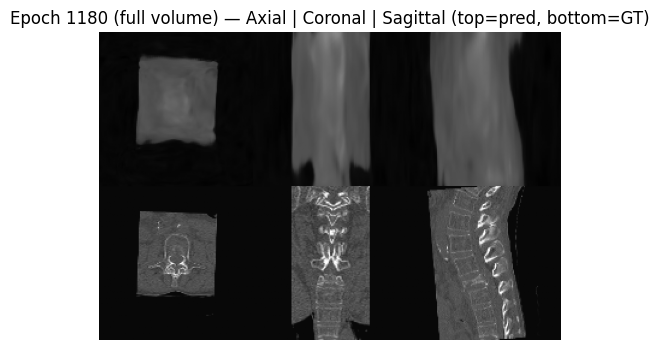

Checkpoint : checkpoints_model_fix/model_epoch1180.pt
Epoch 1181/2000 LR:5.53e-06 | MSE(subset):4.4747e-03 | PSNR~:23.49 dB
Epoch 1182/2000 LR:5.53e-06 | MSE(subset):4.4158e-03 | PSNR~:23.55 dB
Epoch 1183/2000 LR:5.52e-06 | MSE(subset):4.3962e-03 | PSNR~:23.57 dB
Epoch 1184/2000 LR:5.52e-06 | MSE(subset):4.4458e-03 | PSNR~:23.52 dB
Epoch 1185/2000 LR:5.51e-06 | MSE(subset):4.4681e-03 | PSNR~:23.50 dB
Epoch 1186/2000 LR:5.51e-06 | MSE(subset):4.4632e-03 | PSNR~:23.50 dB
Epoch 1187/2000 LR:5.50e-06 | MSE(subset):4.5345e-03 | PSNR~:23.43 dB
Epoch 1188/2000 LR:5.50e-06 | MSE(subset):4.5156e-03 | PSNR~:23.45 dB
Epoch 1189/2000 LR:5.49e-06 | MSE(subset):4.4593e-03 | PSNR~:23.51 dB
Epoch 1190/2000 LR:5.49e-06 | MSE(subset):4.4283e-03 | PSNR~:23.54 dB
Checkpoint : checkpoints_model_fix/model_epoch1190.pt
Epoch 1191/2000 LR:5.48e-06 | MSE(subset):4.3790e-03 | PSNR~:23.59 dB
Epoch 1192/2000 LR:5.48e-06 | MSE(subset):4.3945e-03 | PSNR~:23.57 dB
Epoch 1193/2000 LR:5.47e-06 | MSE(subset):4.4059e-03

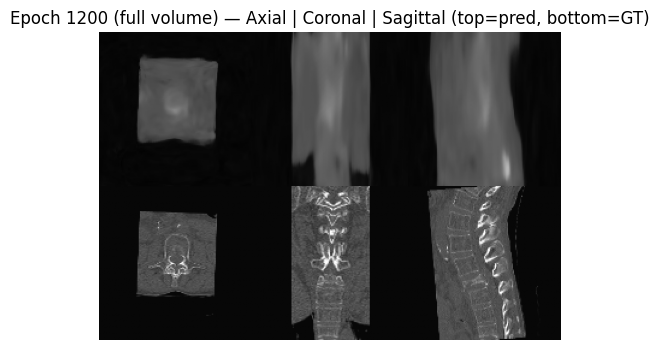

Checkpoint : checkpoints_model_fix/model_epoch1200.pt
Epoch 1201/2000 LR:5.43e-06 | MSE(subset):4.3549e-03 | PSNR~:23.61 dB
Epoch 1202/2000 LR:5.42e-06 | MSE(subset):4.3201e-03 | PSNR~:23.65 dB
Epoch 1203/2000 LR:5.42e-06 | MSE(subset):4.3177e-03 | PSNR~:23.65 dB
Epoch 1204/2000 LR:5.41e-06 | MSE(subset):4.3398e-03 | PSNR~:23.63 dB
Epoch 1205/2000 LR:5.41e-06 | MSE(subset):4.3476e-03 | PSNR~:23.62 dB
Epoch 1206/2000 LR:5.40e-06 | MSE(subset):4.3321e-03 | PSNR~:23.63 dB
Epoch 1207/2000 LR:5.40e-06 | MSE(subset):4.3144e-03 | PSNR~:23.65 dB
Epoch 1208/2000 LR:5.39e-06 | MSE(subset):4.3231e-03 | PSNR~:23.64 dB
Epoch 1209/2000 LR:5.39e-06 | MSE(subset):4.3338e-03 | PSNR~:23.63 dB
Epoch 1210/2000 LR:5.38e-06 | MSE(subset):4.3626e-03 | PSNR~:23.60 dB
Checkpoint : checkpoints_model_fix/model_epoch1210.pt
Epoch 1211/2000 LR:5.38e-06 | MSE(subset):4.2639e-03 | PSNR~:23.70 dB
Epoch 1212/2000 LR:5.37e-06 | MSE(subset):4.2463e-03 | PSNR~:23.72 dB
Epoch 1213/2000 LR:5.37e-06 | MSE(subset):4.2473e-03

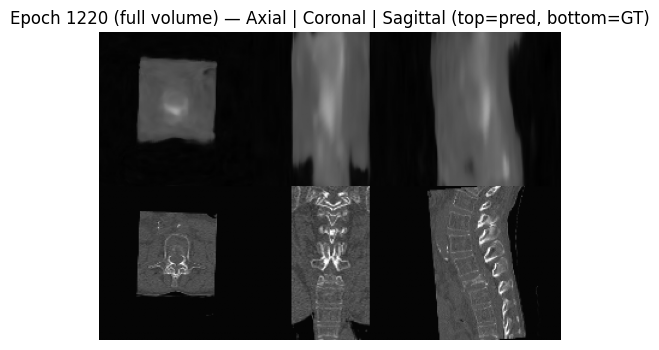

Checkpoint : checkpoints_model_fix/model_epoch1220.pt
Epoch 1221/2000 LR:5.32e-06 | MSE(subset):4.3666e-03 | PSNR~:23.60 dB
Epoch 1222/2000 LR:5.32e-06 | MSE(subset):4.4117e-03 | PSNR~:23.55 dB
Epoch 1223/2000 LR:5.31e-06 | MSE(subset):4.4337e-03 | PSNR~:23.53 dB
Epoch 1224/2000 LR:5.31e-06 | MSE(subset):4.4023e-03 | PSNR~:23.56 dB
Epoch 1225/2000 LR:5.30e-06 | MSE(subset):4.3585e-03 | PSNR~:23.61 dB
Epoch 1226/2000 LR:5.30e-06 | MSE(subset):4.3617e-03 | PSNR~:23.60 dB
Epoch 1227/2000 LR:5.29e-06 | MSE(subset):4.3266e-03 | PSNR~:23.64 dB
Epoch 1228/2000 LR:5.29e-06 | MSE(subset):4.3761e-03 | PSNR~:23.59 dB
Epoch 1229/2000 LR:5.28e-06 | MSE(subset):4.3831e-03 | PSNR~:23.58 dB
Epoch 1230/2000 LR:5.28e-06 | MSE(subset):4.3456e-03 | PSNR~:23.62 dB
Checkpoint : checkpoints_model_fix/model_epoch1230.pt
Epoch 1231/2000 LR:5.27e-06 | MSE(subset):4.2971e-03 | PSNR~:23.67 dB
Epoch 1232/2000 LR:5.27e-06 | MSE(subset):4.2518e-03 | PSNR~:23.71 dB
Epoch 1233/2000 LR:5.26e-06 | MSE(subset):4.2343e-03

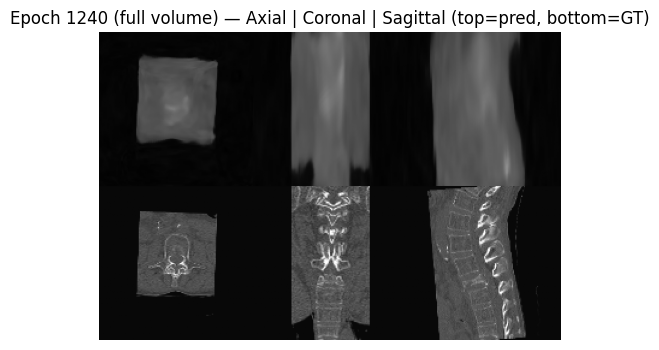

Checkpoint : checkpoints_model_fix/model_epoch1240.pt
Epoch 1241/2000 LR:5.22e-06 | MSE(subset):4.2779e-03 | PSNR~:23.69 dB
Epoch 1242/2000 LR:5.22e-06 | MSE(subset):4.3541e-03 | PSNR~:23.61 dB
Epoch 1243/2000 LR:5.21e-06 | MSE(subset):4.3316e-03 | PSNR~:23.63 dB
Epoch 1244/2000 LR:5.21e-06 | MSE(subset):4.3009e-03 | PSNR~:23.66 dB
Epoch 1245/2000 LR:5.20e-06 | MSE(subset):4.3488e-03 | PSNR~:23.62 dB
Epoch 1246/2000 LR:5.20e-06 | MSE(subset):4.3088e-03 | PSNR~:23.66 dB
Epoch 1247/2000 LR:5.19e-06 | MSE(subset):4.2835e-03 | PSNR~:23.68 dB
Epoch 1248/2000 LR:5.19e-06 | MSE(subset):4.3098e-03 | PSNR~:23.66 dB
Epoch 1249/2000 LR:5.18e-06 | MSE(subset):4.3196e-03 | PSNR~:23.65 dB
Epoch 1250/2000 LR:5.18e-06 | MSE(subset):4.3115e-03 | PSNR~:23.65 dB
Checkpoint : checkpoints_model_fix/model_epoch1250.pt
Epoch 1251/2000 LR:5.17e-06 | MSE(subset):4.3744e-03 | PSNR~:23.59 dB
Epoch 1252/2000 LR:5.17e-06 | MSE(subset):4.4023e-03 | PSNR~:23.56 dB
Epoch 1253/2000 LR:5.16e-06 | MSE(subset):4.4281e-03

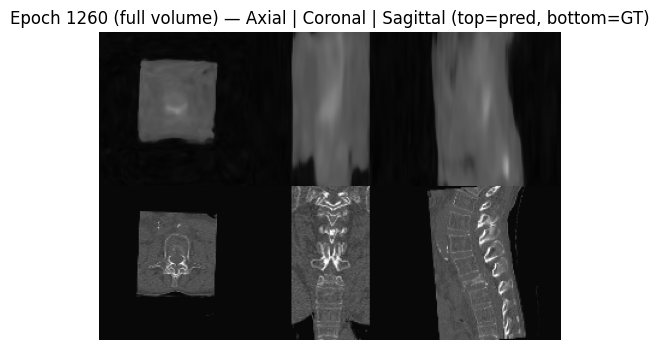

Checkpoint : checkpoints_model_fix/model_epoch1260.pt
Epoch 1261/2000 LR:5.12e-06 | MSE(subset):4.3201e-03 | PSNR~:23.65 dB
Epoch 1262/2000 LR:5.11e-06 | MSE(subset):4.2876e-03 | PSNR~:23.68 dB
Epoch 1263/2000 LR:5.11e-06 | MSE(subset):4.2933e-03 | PSNR~:23.67 dB
Epoch 1264/2000 LR:5.10e-06 | MSE(subset):4.2898e-03 | PSNR~:23.68 dB
Epoch 1265/2000 LR:5.10e-06 | MSE(subset):4.2693e-03 | PSNR~:23.70 dB
Epoch 1266/2000 LR:5.09e-06 | MSE(subset):4.2480e-03 | PSNR~:23.72 dB
Epoch 1267/2000 LR:5.09e-06 | MSE(subset):4.2223e-03 | PSNR~:23.74 dB
Epoch 1268/2000 LR:5.08e-06 | MSE(subset):4.2410e-03 | PSNR~:23.73 dB
Epoch 1269/2000 LR:5.08e-06 | MSE(subset):4.2481e-03 | PSNR~:23.72 dB
Epoch 1270/2000 LR:5.07e-06 | MSE(subset):4.2246e-03 | PSNR~:23.74 dB
Checkpoint : checkpoints_model_fix/model_epoch1270.pt
Epoch 1271/2000 LR:5.07e-06 | MSE(subset):4.2437e-03 | PSNR~:23.72 dB
Epoch 1272/2000 LR:5.06e-06 | MSE(subset):4.2241e-03 | PSNR~:23.74 dB
Epoch 1273/2000 LR:5.06e-06 | MSE(subset):4.2750e-03

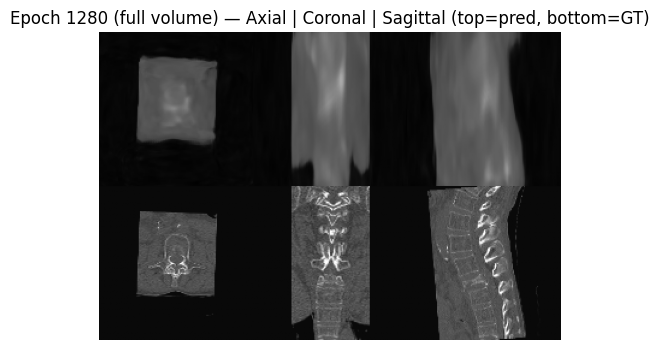

Checkpoint : checkpoints_model_fix/model_epoch1280.pt
Epoch 1281/2000 LR:5.02e-06 | MSE(subset):4.2338e-03 | PSNR~:23.73 dB
Epoch 1282/2000 LR:5.01e-06 | MSE(subset):4.2805e-03 | PSNR~:23.69 dB
Epoch 1283/2000 LR:5.01e-06 | MSE(subset):4.2679e-03 | PSNR~:23.70 dB
Epoch 1284/2000 LR:5.00e-06 | MSE(subset):4.3312e-03 | PSNR~:23.63 dB
Epoch 1285/2000 LR:5.00e-06 | MSE(subset):4.3426e-03 | PSNR~:23.62 dB
Epoch 1286/2000 LR:4.99e-06 | MSE(subset):4.3956e-03 | PSNR~:23.57 dB
Epoch 1287/2000 LR:4.99e-06 | MSE(subset):4.2500e-03 | PSNR~:23.72 dB
Epoch 1288/2000 LR:4.98e-06 | MSE(subset):4.2525e-03 | PSNR~:23.71 dB
Epoch 1289/2000 LR:4.98e-06 | MSE(subset):4.2630e-03 | PSNR~:23.70 dB
Epoch 1290/2000 LR:4.97e-06 | MSE(subset):4.3002e-03 | PSNR~:23.67 dB
Checkpoint : checkpoints_model_fix/model_epoch1290.pt
Epoch 1291/2000 LR:4.97e-06 | MSE(subset):4.2937e-03 | PSNR~:23.67 dB
Epoch 1292/2000 LR:4.96e-06 | MSE(subset):4.3162e-03 | PSNR~:23.65 dB
Epoch 1293/2000 LR:4.96e-06 | MSE(subset):4.2885e-03

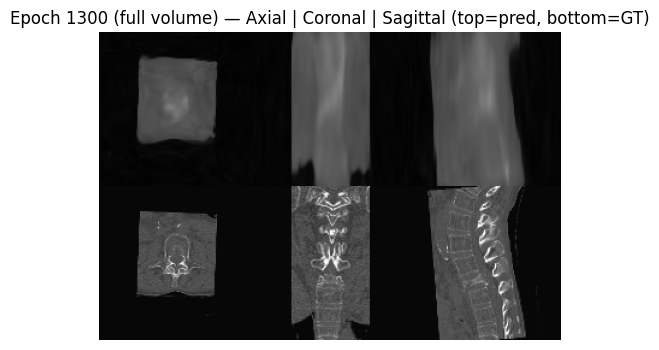

Checkpoint : checkpoints_model_fix/model_epoch1300.pt
Epoch 1301/2000 LR:4.92e-06 | MSE(subset):4.2475e-03 | PSNR~:23.72 dB
Epoch 1302/2000 LR:4.91e-06 | MSE(subset):4.2641e-03 | PSNR~:23.70 dB
Epoch 1303/2000 LR:4.91e-06 | MSE(subset):4.1977e-03 | PSNR~:23.77 dB
Epoch 1304/2000 LR:4.90e-06 | MSE(subset):4.1684e-03 | PSNR~:23.80 dB
Epoch 1305/2000 LR:4.90e-06 | MSE(subset):4.1877e-03 | PSNR~:23.78 dB
Epoch 1306/2000 LR:4.90e-06 | MSE(subset):4.1692e-03 | PSNR~:23.80 dB
Epoch 1307/2000 LR:4.89e-06 | MSE(subset):4.2074e-03 | PSNR~:23.76 dB
Epoch 1308/2000 LR:4.89e-06 | MSE(subset):4.1707e-03 | PSNR~:23.80 dB
Epoch 1309/2000 LR:4.88e-06 | MSE(subset):4.2091e-03 | PSNR~:23.76 dB
Epoch 1310/2000 LR:4.88e-06 | MSE(subset):4.1872e-03 | PSNR~:23.78 dB
Checkpoint : checkpoints_model_fix/model_epoch1310.pt
Epoch 1311/2000 LR:4.87e-06 | MSE(subset):4.1598e-03 | PSNR~:23.81 dB
Epoch 1312/2000 LR:4.87e-06 | MSE(subset):4.1833e-03 | PSNR~:23.78 dB
Epoch 1313/2000 LR:4.86e-06 | MSE(subset):4.1885e-03

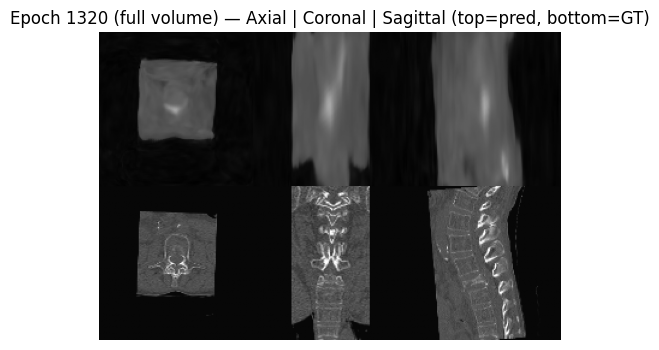

Checkpoint : checkpoints_model_fix/model_epoch1320.pt
Epoch 1321/2000 LR:4.82e-06 | MSE(subset):4.2113e-03 | PSNR~:23.76 dB
Epoch 1322/2000 LR:4.82e-06 | MSE(subset):4.1902e-03 | PSNR~:23.78 dB
Epoch 1323/2000 LR:4.81e-06 | MSE(subset):4.2200e-03 | PSNR~:23.75 dB
Epoch 1324/2000 LR:4.81e-06 | MSE(subset):4.2776e-03 | PSNR~:23.69 dB
Epoch 1325/2000 LR:4.80e-06 | MSE(subset):4.3120e-03 | PSNR~:23.65 dB
Epoch 1326/2000 LR:4.80e-06 | MSE(subset):4.3632e-03 | PSNR~:23.60 dB
Epoch 1327/2000 LR:4.79e-06 | MSE(subset):4.2558e-03 | PSNR~:23.71 dB
Epoch 1328/2000 LR:4.79e-06 | MSE(subset):4.1871e-03 | PSNR~:23.78 dB
Epoch 1329/2000 LR:4.78e-06 | MSE(subset):4.2064e-03 | PSNR~:23.76 dB
Epoch 1330/2000 LR:4.78e-06 | MSE(subset):4.2124e-03 | PSNR~:23.75 dB
Checkpoint : checkpoints_model_fix/model_epoch1330.pt
Epoch 1331/2000 LR:4.77e-06 | MSE(subset):4.1656e-03 | PSNR~:23.80 dB
Epoch 1332/2000 LR:4.77e-06 | MSE(subset):4.1244e-03 | PSNR~:23.85 dB
Epoch 1333/2000 LR:4.76e-06 | MSE(subset):4.1636e-03

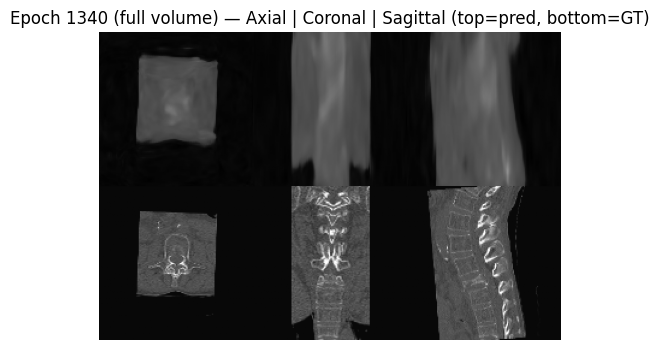

Checkpoint : checkpoints_model_fix/model_epoch1340.pt
Epoch 1341/2000 LR:4.73e-06 | MSE(subset):4.1745e-03 | PSNR~:23.79 dB
Epoch 1342/2000 LR:4.72e-06 | MSE(subset):4.1942e-03 | PSNR~:23.77 dB
Epoch 1343/2000 LR:4.72e-06 | MSE(subset):4.1646e-03 | PSNR~:23.80 dB
Epoch 1344/2000 LR:4.71e-06 | MSE(subset):4.1994e-03 | PSNR~:23.77 dB
Epoch 1345/2000 LR:4.71e-06 | MSE(subset):4.2083e-03 | PSNR~:23.76 dB
Epoch 1346/2000 LR:4.70e-06 | MSE(subset):4.1603e-03 | PSNR~:23.81 dB
Epoch 1347/2000 LR:4.70e-06 | MSE(subset):4.1431e-03 | PSNR~:23.83 dB
Epoch 1348/2000 LR:4.69e-06 | MSE(subset):4.1497e-03 | PSNR~:23.82 dB
Epoch 1349/2000 LR:4.69e-06 | MSE(subset):4.2379e-03 | PSNR~:23.73 dB
Epoch 1350/2000 LR:4.68e-06 | MSE(subset):4.2208e-03 | PSNR~:23.75 dB
Checkpoint : checkpoints_model_fix/model_epoch1350.pt
Epoch 1351/2000 LR:4.68e-06 | MSE(subset):4.1973e-03 | PSNR~:23.77 dB
Epoch 1352/2000 LR:4.67e-06 | MSE(subset):4.1845e-03 | PSNR~:23.78 dB
Epoch 1353/2000 LR:4.67e-06 | MSE(subset):4.1823e-03

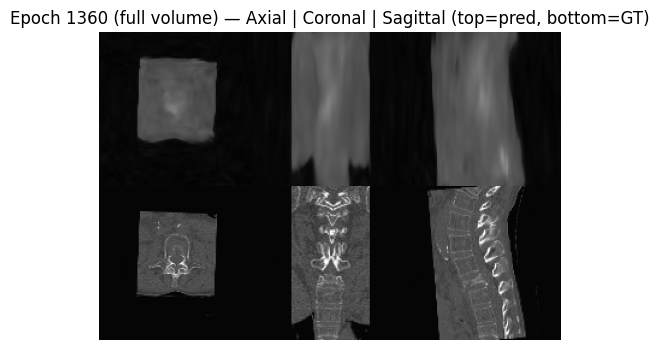

Checkpoint : checkpoints_model_fix/model_epoch1360.pt
Epoch 1361/2000 LR:4.63e-06 | MSE(subset):4.1024e-03 | PSNR~:23.87 dB
Epoch 1362/2000 LR:4.63e-06 | MSE(subset):4.1118e-03 | PSNR~:23.86 dB
Epoch 1363/2000 LR:4.62e-06 | MSE(subset):4.1262e-03 | PSNR~:23.84 dB
Epoch 1364/2000 LR:4.62e-06 | MSE(subset):4.1136e-03 | PSNR~:23.86 dB
Epoch 1365/2000 LR:4.61e-06 | MSE(subset):4.1655e-03 | PSNR~:23.80 dB
Epoch 1366/2000 LR:4.61e-06 | MSE(subset):4.2283e-03 | PSNR~:23.74 dB
Epoch 1367/2000 LR:4.60e-06 | MSE(subset):4.2184e-03 | PSNR~:23.75 dB
Epoch 1368/2000 LR:4.60e-06 | MSE(subset):4.1923e-03 | PSNR~:23.78 dB
Epoch 1369/2000 LR:4.59e-06 | MSE(subset):4.1395e-03 | PSNR~:23.83 dB
Epoch 1370/2000 LR:4.59e-06 | MSE(subset):4.1523e-03 | PSNR~:23.82 dB
Checkpoint : checkpoints_model_fix/model_epoch1370.pt
Epoch 1371/2000 LR:4.59e-06 | MSE(subset):4.2330e-03 | PSNR~:23.73 dB
Epoch 1372/2000 LR:4.58e-06 | MSE(subset):4.1826e-03 | PSNR~:23.79 dB
Epoch 1373/2000 LR:4.58e-06 | MSE(subset):4.2046e-03

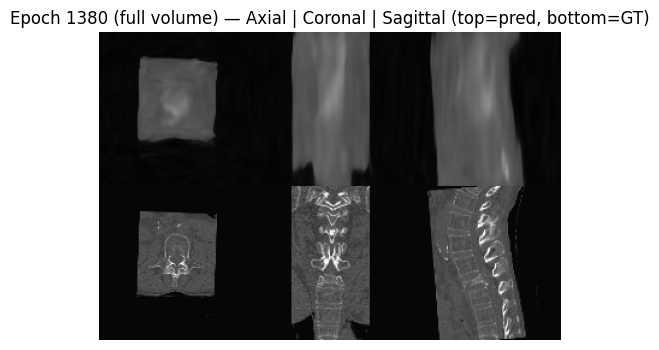

Checkpoint : checkpoints_model_fix/model_epoch1380.pt
Epoch 1381/2000 LR:4.54e-06 | MSE(subset):4.0910e-03 | PSNR~:23.88 dB
Epoch 1382/2000 LR:4.54e-06 | MSE(subset):4.1490e-03 | PSNR~:23.82 dB
Epoch 1383/2000 LR:4.53e-06 | MSE(subset):4.2015e-03 | PSNR~:23.77 dB
Epoch 1384/2000 LR:4.53e-06 | MSE(subset):4.1813e-03 | PSNR~:23.79 dB
Epoch 1385/2000 LR:4.52e-06 | MSE(subset):4.1084e-03 | PSNR~:23.86 dB
Epoch 1386/2000 LR:4.52e-06 | MSE(subset):4.0888e-03 | PSNR~:23.88 dB
Epoch 1387/2000 LR:4.51e-06 | MSE(subset):4.1101e-03 | PSNR~:23.86 dB
Epoch 1388/2000 LR:4.51e-06 | MSE(subset):4.0880e-03 | PSNR~:23.88 dB
Epoch 1389/2000 LR:4.50e-06 | MSE(subset):4.1426e-03 | PSNR~:23.83 dB
Epoch 1390/2000 LR:4.50e-06 | MSE(subset):4.1863e-03 | PSNR~:23.78 dB
Checkpoint : checkpoints_model_fix/model_epoch1390.pt
Epoch 1391/2000 LR:4.49e-06 | MSE(subset):4.1868e-03 | PSNR~:23.78 dB
Epoch 1392/2000 LR:4.49e-06 | MSE(subset):4.1346e-03 | PSNR~:23.84 dB
Epoch 1393/2000 LR:4.49e-06 | MSE(subset):4.1466e-03

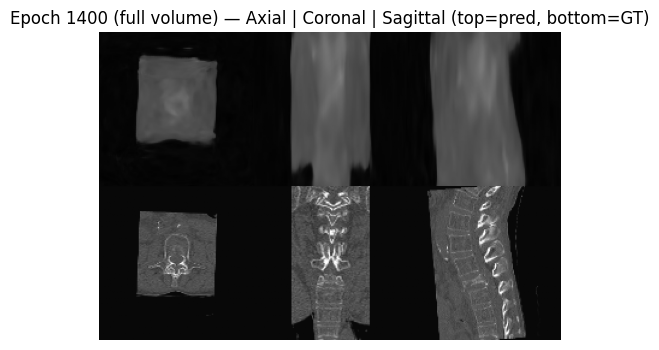

Checkpoint : checkpoints_model_fix/model_epoch1400.pt
Epoch 1401/2000 LR:4.45e-06 | MSE(subset):4.0952e-03 | PSNR~:23.88 dB
Epoch 1402/2000 LR:4.44e-06 | MSE(subset):4.1153e-03 | PSNR~:23.86 dB
Epoch 1403/2000 LR:4.44e-06 | MSE(subset):4.1096e-03 | PSNR~:23.86 dB
Epoch 1404/2000 LR:4.44e-06 | MSE(subset):4.0640e-03 | PSNR~:23.91 dB
Epoch 1405/2000 LR:4.43e-06 | MSE(subset):4.0701e-03 | PSNR~:23.90 dB
Epoch 1406/2000 LR:4.43e-06 | MSE(subset):4.1063e-03 | PSNR~:23.87 dB
Epoch 1407/2000 LR:4.42e-06 | MSE(subset):4.1353e-03 | PSNR~:23.83 dB
Epoch 1408/2000 LR:4.42e-06 | MSE(subset):4.1601e-03 | PSNR~:23.81 dB
Epoch 1409/2000 LR:4.41e-06 | MSE(subset):4.1265e-03 | PSNR~:23.84 dB
Epoch 1410/2000 LR:4.41e-06 | MSE(subset):4.1013e-03 | PSNR~:23.87 dB
Checkpoint : checkpoints_model_fix/model_epoch1410.pt
Epoch 1411/2000 LR:4.41e-06 | MSE(subset):4.1750e-03 | PSNR~:23.79 dB
Epoch 1412/2000 LR:4.40e-06 | MSE(subset):4.1262e-03 | PSNR~:23.84 dB
Epoch 1413/2000 LR:4.40e-06 | MSE(subset):4.1040e-03

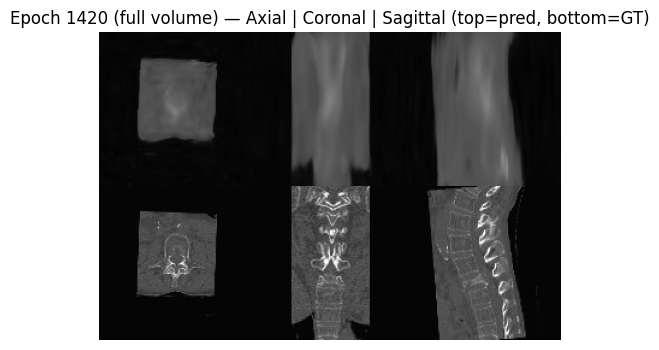

Checkpoint : checkpoints_model_fix/model_epoch1420.pt
Epoch 1421/2000 LR:4.36e-06 | MSE(subset):4.0982e-03 | PSNR~:23.87 dB
Epoch 1422/2000 LR:4.36e-06 | MSE(subset):4.0753e-03 | PSNR~:23.90 dB
Epoch 1423/2000 LR:4.35e-06 | MSE(subset):4.0862e-03 | PSNR~:23.89 dB
Epoch 1424/2000 LR:4.35e-06 | MSE(subset):4.0572e-03 | PSNR~:23.92 dB
Epoch 1425/2000 LR:4.34e-06 | MSE(subset):4.0746e-03 | PSNR~:23.90 dB
Epoch 1426/2000 LR:4.34e-06 | MSE(subset):4.0869e-03 | PSNR~:23.89 dB
Epoch 1427/2000 LR:4.34e-06 | MSE(subset):4.0666e-03 | PSNR~:23.91 dB
Epoch 1428/2000 LR:4.33e-06 | MSE(subset):4.0558e-03 | PSNR~:23.92 dB
Epoch 1429/2000 LR:4.33e-06 | MSE(subset):4.0373e-03 | PSNR~:23.94 dB
Epoch 1430/2000 LR:4.32e-06 | MSE(subset):4.0250e-03 | PSNR~:23.95 dB
Checkpoint : checkpoints_model_fix/model_epoch1430.pt
Epoch 1431/2000 LR:4.32e-06 | MSE(subset):4.0479e-03 | PSNR~:23.93 dB
Epoch 1432/2000 LR:4.31e-06 | MSE(subset):4.0964e-03 | PSNR~:23.88 dB
Epoch 1433/2000 LR:4.31e-06 | MSE(subset):4.0665e-03

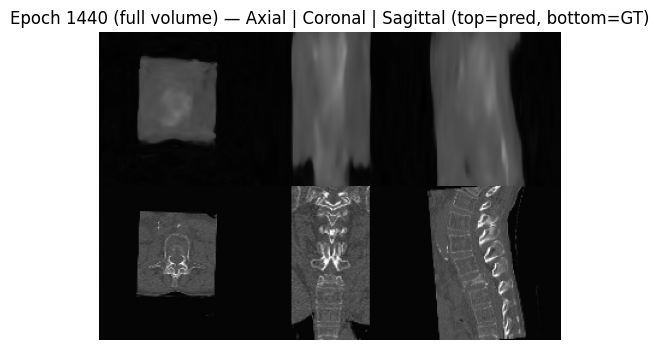

Checkpoint : checkpoints_model_fix/model_epoch1440.pt
Epoch 1441/2000 LR:4.27e-06 | MSE(subset):4.1050e-03 | PSNR~:23.87 dB
Epoch 1442/2000 LR:4.27e-06 | MSE(subset):4.1102e-03 | PSNR~:23.86 dB
Epoch 1443/2000 LR:4.27e-06 | MSE(subset):4.2292e-03 | PSNR~:23.74 dB
Epoch 1444/2000 LR:4.26e-06 | MSE(subset):4.2425e-03 | PSNR~:23.72 dB
Epoch 1445/2000 LR:4.26e-06 | MSE(subset):4.1352e-03 | PSNR~:23.84 dB
Epoch 1446/2000 LR:4.25e-06 | MSE(subset):4.1229e-03 | PSNR~:23.85 dB
Epoch 1447/2000 LR:4.25e-06 | MSE(subset):4.0575e-03 | PSNR~:23.92 dB
Epoch 1448/2000 LR:4.25e-06 | MSE(subset):4.0368e-03 | PSNR~:23.94 dB
Epoch 1449/2000 LR:4.24e-06 | MSE(subset):4.0651e-03 | PSNR~:23.91 dB
Epoch 1450/2000 LR:4.24e-06 | MSE(subset):4.0258e-03 | PSNR~:23.95 dB
Checkpoint : checkpoints_model_fix/model_epoch1450.pt
Epoch 1451/2000 LR:4.23e-06 | MSE(subset):4.0231e-03 | PSNR~:23.95 dB
Epoch 1452/2000 LR:4.23e-06 | MSE(subset):4.0480e-03 | PSNR~:23.93 dB
Epoch 1453/2000 LR:4.22e-06 | MSE(subset):4.0795e-03

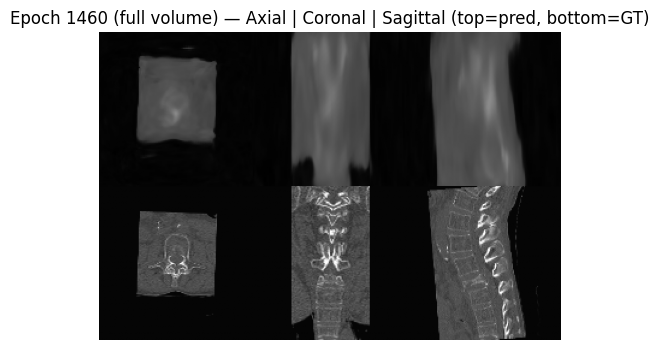

Checkpoint : checkpoints_model_fix/model_epoch1460.pt
Epoch 1461/2000 LR:4.19e-06 | MSE(subset):4.1063e-03 | PSNR~:23.87 dB
Epoch 1462/2000 LR:4.19e-06 | MSE(subset):4.0718e-03 | PSNR~:23.90 dB
Epoch 1463/2000 LR:4.18e-06 | MSE(subset):4.1159e-03 | PSNR~:23.86 dB
Epoch 1464/2000 LR:4.18e-06 | MSE(subset):4.1132e-03 | PSNR~:23.86 dB
Epoch 1465/2000 LR:4.17e-06 | MSE(subset):4.0877e-03 | PSNR~:23.89 dB
Epoch 1466/2000 LR:4.17e-06 | MSE(subset):4.0323e-03 | PSNR~:23.94 dB
Epoch 1467/2000 LR:4.17e-06 | MSE(subset):3.9685e-03 | PSNR~:24.01 dB
Epoch 1468/2000 LR:4.16e-06 | MSE(subset):3.9849e-03 | PSNR~:24.00 dB
Epoch 1469/2000 LR:4.16e-06 | MSE(subset):4.0358e-03 | PSNR~:23.94 dB
Epoch 1470/2000 LR:4.15e-06 | MSE(subset):4.1408e-03 | PSNR~:23.83 dB
Checkpoint : checkpoints_model_fix/model_epoch1470.pt
Epoch 1471/2000 LR:4.15e-06 | MSE(subset):4.0871e-03 | PSNR~:23.89 dB
Epoch 1472/2000 LR:4.15e-06 | MSE(subset):3.9966e-03 | PSNR~:23.98 dB
Epoch 1473/2000 LR:4.14e-06 | MSE(subset):4.0273e-03

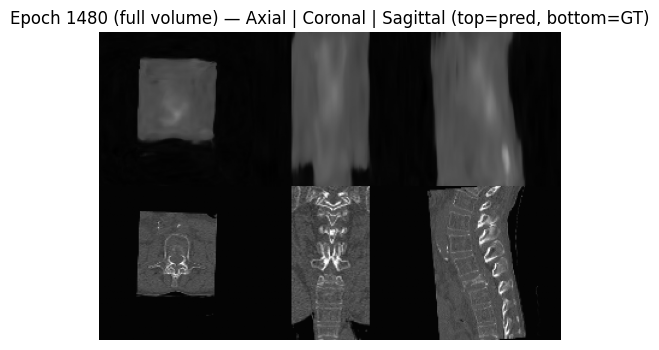

Checkpoint : checkpoints_model_fix/model_epoch1480.pt
Epoch 1481/2000 LR:4.11e-06 | MSE(subset):4.0748e-03 | PSNR~:23.90 dB
Epoch 1482/2000 LR:4.11e-06 | MSE(subset):4.0766e-03 | PSNR~:23.90 dB
Epoch 1483/2000 LR:4.10e-06 | MSE(subset):4.1460e-03 | PSNR~:23.82 dB
Epoch 1484/2000 LR:4.10e-06 | MSE(subset):4.0736e-03 | PSNR~:23.90 dB
Epoch 1485/2000 LR:4.09e-06 | MSE(subset):4.0014e-03 | PSNR~:23.98 dB
Epoch 1486/2000 LR:4.09e-06 | MSE(subset):3.9610e-03 | PSNR~:24.02 dB
Epoch 1487/2000 LR:4.09e-06 | MSE(subset):3.9702e-03 | PSNR~:24.01 dB
Epoch 1488/2000 LR:4.08e-06 | MSE(subset):4.0073e-03 | PSNR~:23.97 dB
Epoch 1489/2000 LR:4.08e-06 | MSE(subset):4.0134e-03 | PSNR~:23.96 dB
Epoch 1490/2000 LR:4.07e-06 | MSE(subset):4.0477e-03 | PSNR~:23.93 dB
Checkpoint : checkpoints_model_fix/model_epoch1490.pt
Epoch 1491/2000 LR:4.07e-06 | MSE(subset):4.0736e-03 | PSNR~:23.90 dB
Epoch 1492/2000 LR:4.07e-06 | MSE(subset):4.0317e-03 | PSNR~:23.95 dB
Epoch 1493/2000 LR:4.06e-06 | MSE(subset):4.0044e-03

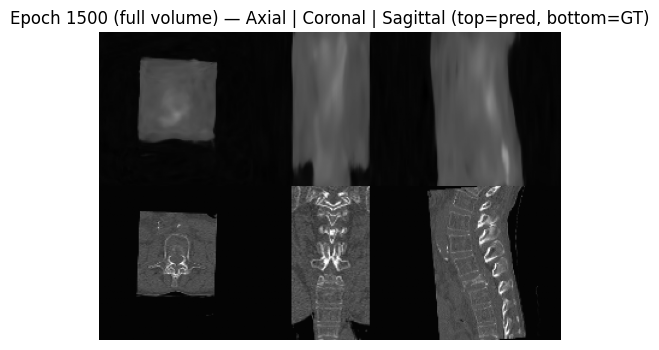

Checkpoint : checkpoints_model_fix/model_epoch1500.pt
Epoch 1501/2000 LR:4.03e-06 | MSE(subset):4.0704e-03 | PSNR~:23.90 dB
Epoch 1502/2000 LR:4.03e-06 | MSE(subset):4.0092e-03 | PSNR~:23.97 dB
Epoch 1503/2000 LR:4.02e-06 | MSE(subset):3.9982e-03 | PSNR~:23.98 dB
Epoch 1504/2000 LR:4.02e-06 | MSE(subset):3.9682e-03 | PSNR~:24.01 dB
Epoch 1505/2000 LR:4.01e-06 | MSE(subset):3.9910e-03 | PSNR~:23.99 dB
Epoch 1506/2000 LR:4.01e-06 | MSE(subset):4.0296e-03 | PSNR~:23.95 dB
Epoch 1507/2000 LR:4.01e-06 | MSE(subset):4.0509e-03 | PSNR~:23.92 dB
Epoch 1508/2000 LR:4.00e-06 | MSE(subset):4.0330e-03 | PSNR~:23.94 dB
Epoch 1509/2000 LR:4.00e-06 | MSE(subset):4.0605e-03 | PSNR~:23.91 dB
Epoch 1510/2000 LR:4.00e-06 | MSE(subset):4.0312e-03 | PSNR~:23.95 dB
Checkpoint : checkpoints_model_fix/model_epoch1510.pt
Epoch 1511/2000 LR:3.99e-06 | MSE(subset):3.9823e-03 | PSNR~:24.00 dB
Epoch 1512/2000 LR:3.99e-06 | MSE(subset):4.0115e-03 | PSNR~:23.97 dB
Epoch 1513/2000 LR:3.98e-06 | MSE(subset):4.0188e-03

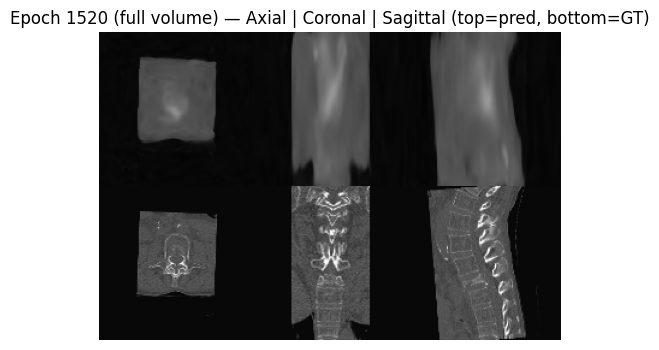

Checkpoint : checkpoints_model_fix/model_epoch1520.pt
Epoch 1521/2000 LR:3.95e-06 | MSE(subset):4.0032e-03 | PSNR~:23.98 dB
Epoch 1522/2000 LR:3.95e-06 | MSE(subset):3.9925e-03 | PSNR~:23.99 dB
Epoch 1523/2000 LR:3.95e-06 | MSE(subset):4.0521e-03 | PSNR~:23.92 dB
Epoch 1524/2000 LR:3.94e-06 | MSE(subset):4.0845e-03 | PSNR~:23.89 dB
Epoch 1525/2000 LR:3.94e-06 | MSE(subset):4.0357e-03 | PSNR~:23.94 dB
Epoch 1526/2000 LR:3.93e-06 | MSE(subset):3.9787e-03 | PSNR~:24.00 dB
Epoch 1527/2000 LR:3.93e-06 | MSE(subset):3.9588e-03 | PSNR~:24.02 dB
Epoch 1528/2000 LR:3.93e-06 | MSE(subset):3.9796e-03 | PSNR~:24.00 dB
Epoch 1529/2000 LR:3.92e-06 | MSE(subset):3.9650e-03 | PSNR~:24.02 dB
Epoch 1530/2000 LR:3.92e-06 | MSE(subset):3.9622e-03 | PSNR~:24.02 dB
Checkpoint : checkpoints_model_fix/model_epoch1530.pt
Epoch 1531/2000 LR:3.92e-06 | MSE(subset):3.9824e-03 | PSNR~:24.00 dB
Epoch 1532/2000 LR:3.91e-06 | MSE(subset):3.9389e-03 | PSNR~:24.05 dB
Epoch 1533/2000 LR:3.91e-06 | MSE(subset):3.9265e-03

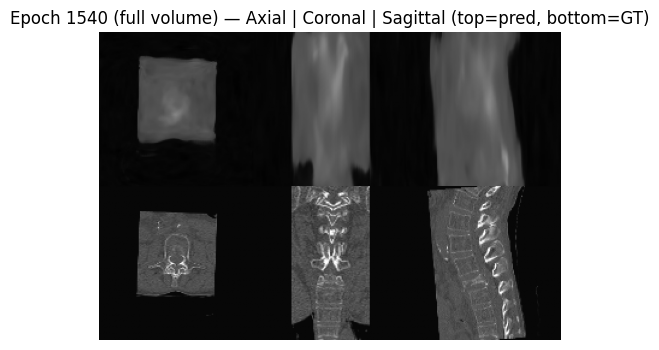

Checkpoint : checkpoints_model_fix/model_epoch1540.pt
Epoch 1541/2000 LR:3.88e-06 | MSE(subset):4.0613e-03 | PSNR~:23.91 dB
Epoch 1542/2000 LR:3.88e-06 | MSE(subset):4.0504e-03 | PSNR~:23.93 dB
Epoch 1543/2000 LR:3.87e-06 | MSE(subset):4.0358e-03 | PSNR~:23.94 dB
Epoch 1544/2000 LR:3.87e-06 | MSE(subset):4.0161e-03 | PSNR~:23.96 dB
Epoch 1545/2000 LR:3.86e-06 | MSE(subset):4.0163e-03 | PSNR~:23.96 dB
Epoch 1546/2000 LR:3.86e-06 | MSE(subset):4.0252e-03 | PSNR~:23.95 dB
Epoch 1547/2000 LR:3.86e-06 | MSE(subset):4.0893e-03 | PSNR~:23.88 dB
Epoch 1548/2000 LR:3.85e-06 | MSE(subset):4.0200e-03 | PSNR~:23.96 dB
Epoch 1549/2000 LR:3.85e-06 | MSE(subset):4.0118e-03 | PSNR~:23.97 dB
Epoch 1550/2000 LR:3.85e-06 | MSE(subset):4.0235e-03 | PSNR~:23.95 dB
Checkpoint : checkpoints_model_fix/model_epoch1550.pt
Epoch 1551/2000 LR:3.84e-06 | MSE(subset):4.0139e-03 | PSNR~:23.96 dB
Epoch 1552/2000 LR:3.84e-06 | MSE(subset):3.9963e-03 | PSNR~:23.98 dB
Epoch 1553/2000 LR:3.84e-06 | MSE(subset):3.9448e-03

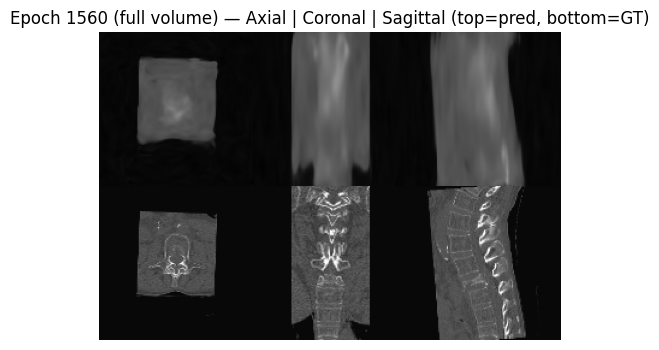

Checkpoint : checkpoints_model_fix/model_epoch1560.pt
Epoch 1561/2000 LR:3.81e-06 | MSE(subset):4.0473e-03 | PSNR~:23.93 dB
Epoch 1562/2000 LR:3.80e-06 | MSE(subset):3.9825e-03 | PSNR~:24.00 dB
Epoch 1563/2000 LR:3.80e-06 | MSE(subset):3.9418e-03 | PSNR~:24.04 dB
Epoch 1564/2000 LR:3.80e-06 | MSE(subset):3.9612e-03 | PSNR~:24.02 dB
Epoch 1565/2000 LR:3.79e-06 | MSE(subset):3.9633e-03 | PSNR~:24.02 dB
Epoch 1566/2000 LR:3.79e-06 | MSE(subset):3.9891e-03 | PSNR~:23.99 dB
Epoch 1567/2000 LR:3.79e-06 | MSE(subset):3.9878e-03 | PSNR~:23.99 dB
Epoch 1568/2000 LR:3.78e-06 | MSE(subset):3.9787e-03 | PSNR~:24.00 dB
Epoch 1569/2000 LR:3.78e-06 | MSE(subset):3.9373e-03 | PSNR~:24.05 dB
Epoch 1570/2000 LR:3.78e-06 | MSE(subset):3.9581e-03 | PSNR~:24.03 dB
Checkpoint : checkpoints_model_fix/model_epoch1570.pt
Epoch 1571/2000 LR:3.77e-06 | MSE(subset):3.9734e-03 | PSNR~:24.01 dB
Epoch 1572/2000 LR:3.77e-06 | MSE(subset):4.0060e-03 | PSNR~:23.97 dB
Epoch 1573/2000 LR:3.77e-06 | MSE(subset):4.0478e-03

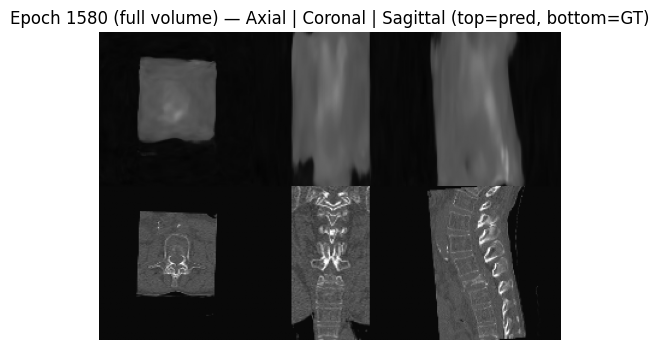

Checkpoint : checkpoints_model_fix/model_epoch1580.pt
Epoch 1581/2000 LR:3.74e-06 | MSE(subset):3.9393e-03 | PSNR~:24.05 dB
Epoch 1582/2000 LR:3.73e-06 | MSE(subset):3.9508e-03 | PSNR~:24.03 dB
Epoch 1583/2000 LR:3.73e-06 | MSE(subset):3.9488e-03 | PSNR~:24.04 dB
Epoch 1584/2000 LR:3.73e-06 | MSE(subset):3.9636e-03 | PSNR~:24.02 dB
Epoch 1585/2000 LR:3.72e-06 | MSE(subset):3.9557e-03 | PSNR~:24.03 dB
Epoch 1586/2000 LR:3.72e-06 | MSE(subset):3.9256e-03 | PSNR~:24.06 dB
Epoch 1587/2000 LR:3.72e-06 | MSE(subset):3.9408e-03 | PSNR~:24.04 dB
Epoch 1588/2000 LR:3.71e-06 | MSE(subset):3.9577e-03 | PSNR~:24.03 dB
Epoch 1589/2000 LR:3.71e-06 | MSE(subset):3.9756e-03 | PSNR~:24.01 dB
Epoch 1590/2000 LR:3.71e-06 | MSE(subset):3.9483e-03 | PSNR~:24.04 dB
Checkpoint : checkpoints_model_fix/model_epoch1590.pt
Epoch 1591/2000 LR:3.70e-06 | MSE(subset):3.9529e-03 | PSNR~:24.03 dB
Epoch 1592/2000 LR:3.70e-06 | MSE(subset):4.0285e-03 | PSNR~:23.95 dB
Epoch 1593/2000 LR:3.70e-06 | MSE(subset):3.9999e-03

In [ ]:
train_model(model, optimG, make_scheduler, CKPT_DIR, resume_epoch=None)